<a href="https://colab.research.google.com/github/ZosoV/aco_random_walk/blob/main/notebooks/aco_pp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Implementation of ACO for Path Planning

This is a python implementation of the Ant Colony Optimization algorithm for the Sorthest Path problem

In [1]:
COLAB_ENV = False

if COLAB_ENV:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Proyectos/aco_random_walk/
else:
    %cd /home/zosov/ACO_Random_Walk

/home/zosov/ACO_Random_Walk


In [2]:
!ls

LICENSE    environment.yml  notebooks	 stuff	     utils
README.md  model	    random_walk  test_rw.py


In [3]:
# import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import enum
import numpy as np
import os
import pandas as pd
from collections import Counter
import time
import pylab as pl
from IPython import display

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED) 

In [4]:
DATA_DIR = "stuff/data/random_mazes/"
SAVING_DIR = "stuff/results/aco_pp/"

if not os.path.exists(DATA_DIR):
  os.mkdir(DATA_DIR)

if not os.path.exists(SAVING_DIR):
  os.mkdir(SAVING_DIR)

# Ant Colony Optimizer

First, we did a little review of the algorithm that we are using. The algorithm is based on **Ant Colony System** with some additional functions, found here
[Ant Colony Optimization: Artificial Ants as a Computational Intelligence Technique](https://ieeexplore.ieee.org/abstract/document/4129846)

## Ant Colony System
This is an iterative algorithm. In each iteration, 

1. A number of ants find differents solutions. To do that, each ant follows a `pseudorandom  proportional rule`. Thus, the probability for an ant to move from city $i$ to city $j$ depends on a random variable $q$ uniformly distributed over $[0,1]$, and a parameter $q_0$. Therefore, if $q \le q_0$, then $j=\arg \max _{c_{i l} \in N(s p)}\left\{\tau_{i l} \eta_{i l}^{\beta}\right\}$, otherwise use the next equation

$$ p_{i j}^{k}=\left\{\begin{array}{ll}
\frac{\tau_{i j}^{\alpha} \cdot \eta_{i j}^{\beta}}{\sum_{c_{i l} \in \mathrm{N}\left(s^{p}\right)} \tau_{i l}^{\alpha} \cdot \eta_{i l}^{\beta}} & \text { if } c_{i j} \in \mathbf{N}\left(s^{p}\right) \\
0 & \text { otherwise }
\end{array}\right. $$

where $\mathrm{N}(s^p)$ is the set of feasible neighbors components; edges $(i,l)$ where $l$ is a feasible neighbor. The parameters $\alpha$ and $\beta$ control the relative importance of the pheromone versus the heurisitc information $\eta_{ij}$


2. A `local pheromone evaporation` is performed by all the ants after each construction step. Each ant applies it only to the last edge traversed:

$$ \tau_{i j}=(1-\varphi) \cdot \tau_{i j}+\varphi \cdot \tau_{0} $$

where $\varphi \in (0,1]$ is the pheromone decay coefficient, and $\tau_{0}$ the initial value pheromone. 

Note: the main goal of `local pheromone evaporation` is to diversify  the search performed by subsequent ants during an iteration.

3. Then, only the best ant updates the pheromone trails (also known as `offline  pheromone  update`), following
$$ \tau_{i j} \leftarrow\left\{\begin{array}{ll}
(1-\rho) \cdot \tau_{i j}+\rho \cdot \Delta \tau_{i j} & \text { if }(i, \jmath) \text { belongs to best tour, } \\
\tau_{i j} & \text { otherwise. }
\end{array}\right. $$

where 

$$ \Delta \tau_{i j}^{\text {best }}=\left\{\begin{array}{ll}
1 / L_{\text {best }} & \text { if }(i, j) \text { belongs to the best tour, } \\
0 & \text { otherwise }
\end{array}\right.
$$

$L_{best}$ is the length of the tour of the best ant. I could be either the best found in the current iteration (*iteration-best*, $L_{ib}$) or the best solution found so far since the start of the algorithm (*best-so-far*, $L_{bs}$).


 




## Base ACO class

In this section, we defined an ant colony optimizer class, which will be used as a base to develop the Travelling Salesman Problem and Path Planning (Shortest Path). In this part, we intended to build a general class that could be inheriting and, with few changes, adapt to any problem that we pretend to solve.


In [5]:
class AntColonyOptimizer():
  def __init__(self, graph, ants, alpha, beta, p, 
               local_p = None, intensity = None, q_0 = None):
    """
    Ant colony optimizer.  Traverse a graph and finds the min weight distance
    :param graph: graph environment
    :param ants:  number of ants to traverse the graph
    :param alpha: weighting of pheromone
    :param beta:  weighting of heuristic
    :param p:     evaporation rate at which pheromone evaporates
    :param local_p: local evaporation rate at which pheromone evaporates (optional)
    :param intensity: the amount of pheromones to add per edge (optional)
    :param q_0: probability to choose the best construction step (optional)
    """
    self.graph = graph
    self.ants = ants
    self.alpha = alpha
    self.beta = beta
    self.p = p
    self.local_p = local_p
    self.intensity = intensity
    self.q_0 = q_0

    self.best_path = []
    self.reset_environment()


  def reset_environment(self):
    """ return to the base state of the environment
    """
    self.current_position = self.start_node
    self.visited_nodes = [self.start_node]
    self.current_path = []

  def is_visited(self, neighbor):
    """return if the neighbor has alreadey been visited
    """
    return neighbor in self.visited_nodes   
  
  def get_total_distance(self, path):
    """return the total distance of the given path
    """
    t_distance = 0
    for node1, node2 in path:
      t_distance += self.graph[node1][node2]['distance']

    # At the beginning, the total distance is define by inf
    if len(path) == 0 : t_distance = float('inf')
    return t_distance

  def update_best_path(self):
    if self.get_total_distance(self.current_path) < self.get_total_distance(self.best_path):
      self.best_path = self.current_path
  
  def local_evaporation(self, neighbor):
    edge = (self.current_position, neighbor)
    self.graph.edges[edge]['pheromone'] = (1 - self.local_p) * self.graph.edges[edge]['pheromone'] + self.local_p * self.graph.tau_0

  def offline_pheromone_update(self):
    """
    Here, it is performed two steps at the same time:

    1. global evaporation of the pheromone using self.p
    2. contribution of pheromones over the best path found so far. The 
    contribution or reward is defined according to the distance of the 
    best path found so far. Also, if intensity is defined you could 
    update using that constant vaue
    """
    cost = self.get_total_distance(self.best_path)
    reward = self.intensity if self.intensity is not None else 1 / cost

    #print("[INFO] Updating current path - cost: {} reward: {}".format(cost, reward))

    for node1, node2, _ in self.graph.edges(data=True):
      # 1. evaporation
      self.graph[node1][node2]['pheromone'] = (1 - self.p) * self.graph[node1][node2]['pheromone']

      # 2. contribution update
      if (node1, node2) in self.best_path or (node2, node1) in self.best_path:
        self.graph[node1][node2]['pheromone'] += reward

# Path Planning (Shortest Path)

First, we define the environment where the algorithm will take place. In this case, the environment is a weighted graph $G(N,E)$ with the the following characteristic:

1. The nodes are joined by equidistance edges, in a lattice form. 
2. Each edge have two weights the equal `distance` ($d=1$) and a `pheromone` value.
3. The nodes have different states, such as: `free`, `obstacle` or `target.`

In [6]:
# creating enumerations for status of a each node
# the number associated represent a mark to display
# the environment later in a grid mode
class State(enum.Enum):
    free = 0.9
    wall = 0.1
    target = 0.5

In [7]:
#Class to define the environment
class PPGraph(nx.Graph):
  def __init__(self, size, tau_0, filename = None):
    """Define a graph environment given a size
    and tau_0 (initial pheromone).
    The obstacle are loaded from filename
    """
    self.size = size
    self.tau_0 = tau_0
    nx.Graph.__init__(self)
    
    self.__create_graph(filename)
    
  def __create_graph(self, filename):
    """Create a square lattice graph with size x size nodes.
    """
    
    walls = np.load(filename) if filename is not None else []
        
    if self.size + 1 in walls: print("What happend?")
        
    self.clear() # Remove all the nodes and edges of the last graph
    current_node = 0
    for j in range(self.size - 1, -1, -1):
      for i in range(self.size):  

          #Adding neighbors to the current node
          self.__adding_edges(i,j,current_node, self.tau_0)

          #Adding the node to the network
          self.add_node(current_node, pos=(i,j), state = State.free, counter = 0)
        
          current_node += 1
            
    for wall_id in walls:
        self.nodes[wall_id]['state'] = State.wall
            
            
  def __adding_edges(self,i,j,current_node, tau_0):
    """Defines the neighbors per current node"""
    #There are four possible connection
    directions = {
        "up" : current_node - self.size,
        "down" : current_node + self.size,
        "left" : current_node - 1,
        "right" : current_node + 1
    }

    #For border cases of the network, we have to pop some connections
    if i == 0:
      directions.pop("left")
    if i == self.size - 1:
      directions.pop("right")
    if j == 0:
      directions.pop("down")
    if j == self.size - 1:
      directions.pop("up")

    for _, neighbor in directions.items():
      # adding edge      
      self.add_edge(current_node, neighbor, 
                    pheromone = tau_0, 
                    distance = 1)


  #Function to plot the structure of the graph
  def draw_graph(self, node_size=25, with_labels=False):
    """
    Draw the graph.
        
    node_size: the size of all the nodes
    node_color: the color of all the nodes
    with_labels: True or False to show the ids of the nodes
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal') #set the x and y axes to the same scale
    pos = nx.get_node_attributes(self, 'pos')
    color_values = [ self.nodes[i]['state'].value for i in self.nodes() ]
    nx.draw(self, pos, cmap = plt.get_cmap('viridis'), node_color=color_values\
            , node_size=node_size, with_labels=with_labels, vmin = 0., vmax = 1.0)


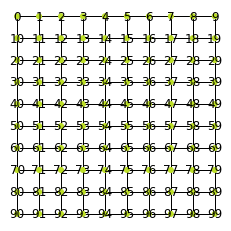

In [8]:
graph = PPGraph(size = 10, tau_0 = 0.1)
graph.draw_graph(with_labels= True)

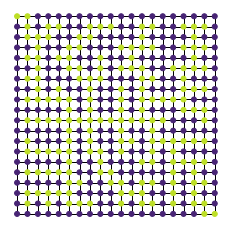

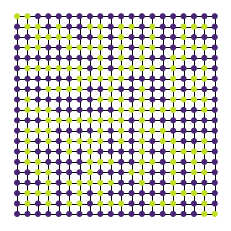

In [9]:
#Loading saving random mazes
SIZE = 20
maze_files = "stuff/data/random_mazes/maze_size_{}/".format(SIZE)
for maze_file in os.listdir(maze_files)[:2]:
    maze_file = os.path.join(maze_files,maze_file)
    graph = PPGraph(size = SIZE, tau_0 = 0.1, filename = maze_file)
    graph.draw_graph()

### Path Planng ACO (ACOPP)

In this version of the algorithm, we did few changes to deal with our problem.

1. `penalty`: A great prevalent problem in this algorithm is the capabality to avoid already visited nodes. In the TSP problem, we solve it only excluding these visited nodes. However, in this case, the algorithm tends to get stuck several times when we do so. This is mainly due to each node is not fully connected with all the other nodes. For this reason, we propose a `penalty` parameter, which reduces the pheromones (in a percent) of edges linked with already visited nodes. In this way, we avoid to fall in stuck condition whereas encourage to avoid already visited nodes

2. `proximity`: In this problem, use the heuristic $\eta_{ij}$ as `1 / distance` does not make sense due to all the edges have equal lengths. Thus, we considered a more informative metric, known as `proximity`. The `proximity` represent the **inverse relative distance of a neighbor node to the target node.** 

### Proximity and Multiplication Step

The `proximity` represent the inverse relative distance of a neighbor node to the target node. In this section, we review the distribution of this metric in environments with different sizes. Also, we propose a **proximity 2** to reduce the sparse values. The proximity of current node $i$ respect to the neighbor node $j$ is

$$ \mathrm{proximity1}_{ij} = \frac{1}{d_{jt}} = \eta_{ij} $$

where $d_{jt}$ is the manhattan or euclidean distance of the neighbor node $j$ to the target node $t$.

Additionally, here we propose to multiply the previous inverse distance to $d_{it}$, the distance of the current node $i$ to the target node $t$, as

$$ \mathrm{proximity2}_{ij} = \frac{d_{it}}{d_{jt}} = \eta_{ij} $$



In [10]:
def get_distance(pos1, pos2, distance):
  x1, y1 = pos1
  x2, y2 = pos2
  
  if distance == 'euclidean':
    result = np.sqrt((x2-x1)**2 + (y2-y1)**2)
  elif distance == 'manhattan':
    result = np.abs(x2-x1) + np.abs(y2-y1)

  return result

In [11]:
def get_proximity(graph, current_node, neighbor_node, target_node, 
                  mode = 'proximity_1', distance = 'euclidean'):
  """
  Proximity. Calculate the proximity of the neighbor node.
  :param graph:         graph environment
  :param current_node:  index of the current node i
  :param neighbor_node: index of the neihbor node j
  :param target_node:   index of the neihbor node t
  :param mode:          perform the proximity 1 or proximity 2
  :param distance:      used distance to calculate the proximity
  """
  pos_neighbor = graph.nodes[neighbor_node]['pos']
  pos_target = graph.nodes[target_node]['pos']
  pos_current = graph.nodes[current_node]['pos']

  # distance: current node to target
  dis_curr2target = get_distance(pos_current, pos_target, distance)
  
  # distance: neighbor to target
  dis_neig2target = get_distance(pos_neighbor, pos_target, distance)
  
  if neighbor_node == target_node:
    proximity = 1
  else:

    if mode == 'proximity_1':
      proximity = 1/ dis_neig2target
    elif mode == 'proximity_2':
      proximity = dis_curr2target / dis_neig2target

  return proximity

Now, we have the guidelines to the algorithm, here we define a class with all the process, inheriting the base `AntColonyOptimizer` class.

In [12]:
#@title Function to plot the graph in a grid prespective, the pheromones and exploration
def draw_progress(base_class, iter, ant, step, draw_additional = False):
  # Create a canvas to display the visited cells, the ant, and the target
  # values: to traget, free cells, and obstacles
  canvas = [ base_class.graph.nodes[i]['state'].value for i in sorted(base_class.graph.nodes()) ]
  # values: to the visited cells
  for node in base_class.visited_nodes: canvas[node] = 0.2
  # values: to the ant
  canvas[base_class.current_position] = 0.3

  canvas = np.array(canvas).reshape((base_class.size, base_class.size))

  def get_pheromones_per_node(graph):
    pheromones = []
    for i in sorted(graph.nodes()):
        if graph.nodes[i]['state'] != State.wall:
            neighbors = graph[i]
            accu_pheromone = 0
            counter = 0
            for neighbor_node, edge in neighbors.items():
                if graph.nodes[i]['state'] != State.wall:
                    accu_pheromone += edge['pheromone']
                    counter += 1
                
            pheromones.append(accu_pheromone/counter)
        else:
            pheromones.append(0)
            
    return np.array(pheromones).reshape((graph.size, graph.size))

  def draw_grid_inner(ax):
      ax.set_title('Iteration {} - Ant {} - Step {}'.format(iter,ant,step))
      ax.pcolor(canvas, edgecolors='k', cmap='Paired', linewidths=0.2, vmin = 0., vmax = 1.0)
      ax.set_aspect('equal') #set the x and y axes to the same scale
      plt.xticks(np.arange(0.5, base_class.size, step=1), labels=[i for i in range(base_class.size)]) 
      plt.yticks(np.arange(base_class.size - 0.5, 0, step=-1), labels=[i for i in range(base_class.size)])
      ax.invert_yaxis() #invert the y-axis so the first row of data is at the top
  
  def pheromones_plot(fig, ax):
      pheromones = get_pheromones_per_node(base_class.graph)
      im = ax.pcolor(pheromones, edgecolors='k', cmap='viridis', linewidths=0.2)
      ax.set_title('Pheromones Distribution')
      ax.set_aspect('equal') #set the x and y axes to the same scale
      ax.set_xticks([])
      ax.set_yticks([])
      ax.invert_yaxis() #invert the y-axis so the first row of data is at the top
      
      cbar=fig.colorbar(im, label='pheromones amount', ax = ax)
    
  def exploration_plot(fig, ax):
      exploration = [ base_class.graph.nodes[i]['counter'] for i in sorted(base_class.graph.nodes()) ]
      exploration = np.array(exploration).reshape((base_class.size, base_class.size))
      im2 = ax.pcolor(exploration, edgecolors='k', cmap='plasma', linewidths=0.2)
      ax.set_title('Exploration')
      ax.set_aspect('equal') #set the x and y axes to the same scale
      ax.set_xticks([])
      ax.set_yticks([])
      ax.invert_yaxis() #invert the y-axis so the first row of data is at the top
      
      cbar=fig.colorbar(im2, label='number of times visited', ax = ax)
    
  fig, ax = plt.subplots(figsize=(3*base_class.size/4,2*base_class.size/4))

  ax1 = plt.subplot(231)
  ax2 = plt.subplot(232)
  ax3 = plt.subplot(233)

  #ax4 = plt.subplot(212)

  #Plot the maze
  if draw_additional:

      draw_grid_inner(ax1)
        
      pheromones_plot(fig,ax2)
    
      exploration_plot(fig,ax3)
     
      #list_iterations = np.arange(0, len(base_class.list_distances))
      #ax4.plot(list_iterations, base_class.list_distances, "b-") #, label = label)
    
  else:
      draw_grid_inner(ax1)

In [14]:
class ACOPP(AntColonyOptimizer):
  def __init__(self, graph, ants, alpha, beta, p, penalty, local_p = None, intensity = None, q_0 = None):
    """
    Ant colony optimizer for Path Planning.  
    Traverses a graph and finds the min weight distance 
    between a start and target node
    
    :param graph: graph environment
    :param ants:  number of ants to traverse the graph
    :param alpha: weighting of pheromone
    :param beta:  weighting of heuristic
    :param p:     evaporation rate at which pheromone evaporates
    :param local_p: local evaporation rate at which pheromone evaporates (optional)
    :param penalty: penalization percent of already visited nodes 
    :param intensity: the amount of pheromones to add per edge (optional)
    :param q_0: probability to choose the best construction step (optional)
    """    
    self.start_node = 0
    self.penalty = penalty
    self.size = graph.size
    self.target_node = self.size * self.size - 1
    self.list_distances = []

    super().__init__(graph, ants, alpha, beta, p, local_p, intensity, q_0)

    self.graph.nodes[self.graph.size * self.graph.size - 1]['state'] = State.target

  def update_state(self, mode = 'proximity_1', 
                   normalization = None,
                   mean = 0, 
                   std = 1, 
                   distance = 'euclidean'):
    neighbors = self.graph[self.current_position]

    # Process to get the weight of each neighbor
    weights = []
    aux_weights = []
    neighbors_idx = []
    for neighbor_node, edge in neighbors.items():
      if self.graph.nodes[neighbor_node]['state'] != State.wall:
          proximity = get_proximity(self.graph, 
                                    self.current_position,
                                    neighbor_node,
                                    self.target_node,
                                    mode,
                                    distance)
          if normalization is not None:
            proximity = (proximity - mean) / std      

          if not self.is_visited(neighbor_node):
            # get the weight per neighbor and append it
            weights.append( (edge['pheromone'] ** self.alpha) * 
                          (proximity ** self.beta))
            aux_weights.append( edge['pheromone'] * 
                          (proximity ** self.beta))
            neighbors_idx.append(neighbor_node)
          else:
            penalty_pheromone = (1 - self.penalty) * edge['pheromone']
            weights.append( (penalty_pheromone ** self.alpha) * 
                  (proximity ** self.beta))
            aux_weights.append( penalty_pheromone * 
                          (proximity ** self.beta))
            neighbors_idx.append(neighbor_node)
    
    acu_weight = sum(weights)
    probabilities = np.array(weights)/acu_weight
    #print("[INFO] probabilities: {}".format(probabilities))

    # with probability q_0 select the best trial
    if self.q_0 is not None and np.random.rand() < self.q_0:
        new_position = neighbors_idx[np.argmax(aux_weights)]
    else:
      # choose an option following the wheel selection algorithm  
      new_position = np.random.choice(neighbors_idx, p=probabilities)

    # perform local evaporation
    if self.local_p is not None:
      self.local_evaporation(new_position)

    self.graph.nodes[self.current_position]['counter'] += 1
     
    self.current_path.append((self.current_position, new_position))
    self.visited_nodes.append(new_position)
    self.current_position = new_position

  def end_route(self):
    return self.current_position == self.target_node

  def fit(self, total_iter, steps_die = None, draw_mode = None, iter_show_step = 1, 
          speed = 0.05, show_last = False, draw_additional = True):
    # define 2 draw_mode per_iteration or per_ants
    list_distances = []
    list_distances_avg = []
    list_distances_std = []
    list_distances_sem = []
    
    for iter in range(total_iter):

      distance_per_ants = []

      for ant in range(self.ants):
        get_target = False
        is_stuck = False
        step = 0
        while not get_target and not is_stuck:
          self.update_state()
          if show_last:
              if iter == total_iter -1 and ant == self.ants - 1:
                draw_progress(self,iter,ant,step, draw_additional = draw_additional)
                display.clear_output(wait=True)
                display.display(pl.gcf())
                time.sleep(speed)
                plt.clf()
          else:
              if draw_mode == "per_ants" and iter % iter_show_step == 0: 
                    draw_progress(self,iter,ant,step, draw_additional = draw_additional)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    time.sleep(speed)
                    plt.clf()
              if draw_mode == "per_iteration" and ant == self.ants -1 and iter % iter_show_step == 0:
                    draw_progress(self,iter,ant,step, draw_additional = draw_additional)
                    display.clear_output(wait=True)
                    display.display(pl.gcf())
                    time.sleep(speed)
                    plt.clf()            
            
          step += 1
            
          if steps_die == step: 
            is_stuck = True
          get_target = self.end_route()
          if get_target: self.graph.nodes[self.current_position]['counter'] += 1
          
        if not is_stuck: 
            self.update_best_path()
            is_stuck = False
        current_distance = self.get_total_distance(self.current_path)
        #print("[INFO] iter: {} ant: {} current: {}".format(iter, ant, current_distance))
        distance_per_ants.append(current_distance)
        self.reset_environment()

      self.offline_pheromone_update()

      # Track the best distance so far
      best_distance = self.get_total_distance(self.best_path)
      if iter % step_plot == 0:
        print("[INFO] iter: {} best: {} d_mean: {} d_stdv: {}".format(iter, 
                                                              best_distance, 
                                                              np.mean(distance_per_ants),
                                                              np.std(distance_per_ants)))
      list_distances.append(best_distance)
      list_distances_avg.append(np.mean(distance_per_ants))
      list_distances_std.append(np.std(distance_per_ants))
      list_distances_sem.append(np.std(distance_per_ants, ddof=1) / np.sqrt(np.size(distance_per_ants)))
      self.list_distances.append(best_distance)

    history = {
        "distances_best" : list_distances,
        "distances_avg"  : list_distances_avg,
        "distances_std"  : list_distances_std,
        "distances_sem"  : list_distances_sem
    }

    return history


Now execute the algorithm given some parameters in a **free environment**

In [15]:
# Define the parameters of our model
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0
q_0 = 0.3

# Additional attributes
penalty = 0.7 # Nota el grado de penalización provoca que haya mas o menos ruido

total_iter = 40
step_plot = 10

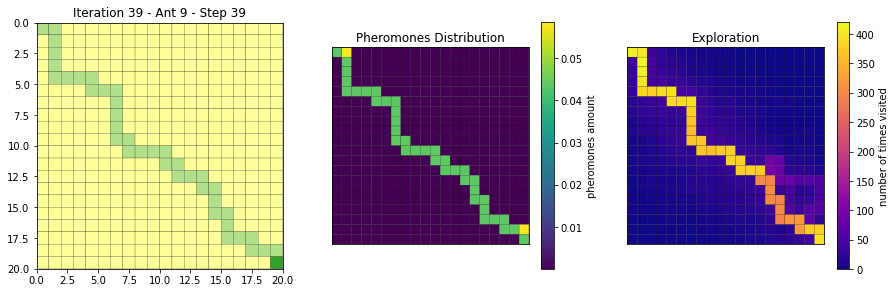

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [16]:
# Create the graph
graph = PPGraph(size = 20, tau_0 = tau_0)

# Create the optimizer using the current graph
optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)

# Execute the optimizer
history = optimizer.fit(total_iter, draw_mode = "per_iteration", show_last = True)

In [97]:
total_iter = 200
step_plot = 10

# Create the graph
graph = PPGraph(size = 100, tau_0 = tau_0)

# Create the optimizer using the current graph
optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)

# Execute the optimizer
history = optimizer.fit(total_iter)

[INFO] iter: 0 best: 392 d_mean: 469.2 d_stdv: 55.56401713339309
[INFO] iter: 10 best: 344 d_mean: 557.2 d_stdv: 131.24999047619013
[INFO] iter: 20 best: 344 d_mean: 783.4 d_stdv: 399.6759187141502
[INFO] iter: 30 best: 344 d_mean: 1019.4 d_stdv: 524.7125308204484
[INFO] iter: 40 best: 344 d_mean: 734.8 d_stdv: 323.0321346244054
[INFO] iter: 50 best: 344 d_mean: 1105.2 d_stdv: 925.041058548214
[INFO] iter: 60 best: 344 d_mean: 594.2 d_stdv: 199.28963846622835
[INFO] iter: 70 best: 344 d_mean: 568.0 d_stdv: 100.25567315618603
[INFO] iter: 80 best: 344 d_mean: 802.8 d_stdv: 288.3764206727034
[INFO] iter: 90 best: 344 d_mean: 1047.6 d_stdv: 602.8491021806368
[INFO] iter: 100 best: 344 d_mean: 623.8 d_stdv: 212.9759610848135
[INFO] iter: 110 best: 344 d_mean: 850.0 d_stdv: 498.3412485436059
[INFO] iter: 120 best: 344 d_mean: 676.2 d_stdv: 208.2084532385753
[INFO] iter: 130 best: 344 d_mean: 727.6 d_stdv: 573.6875804826178
[INFO] iter: 140 best: 344 d_mean: 828.4 d_stdv: 418.29061667697016


In [104]:
!ls stuff/results/aco_pp/histories_evaporation_rate/

history_10_3.0_2.0_0.3_0.3_0.7_500.npy


In [124]:
history = np.load("stuff/results/aco_pp/histories_evaporation_rate/history_10_3.0_2.0_0.3_0.3_0.7_500.npy",  allow_pickle='TRUE').item()

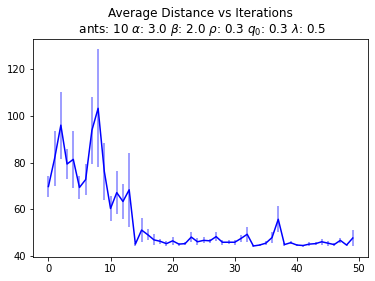

In [130]:
max_bound = 50
text_title = r"ants: {} $\alpha$: {} $\beta$: {} $\rho$: {} $q_0$: {} $\lambda$: {}".format(ants,alpha,beta,p,q_0, penalty)
plot_distance(history['distances_avg'][:max_bound], history['distances_sem'][:max_bound], add_title = text_title)

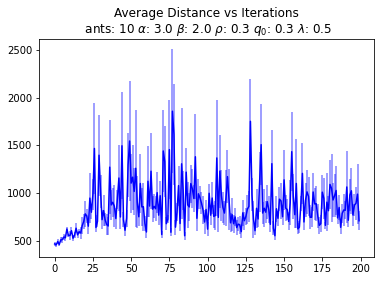

In [98]:
text_title = r"ants: {} $\alpha$: {} $\beta$: {} $\rho$: {} $q_0$: {} $\lambda$: {}".format(ants,alpha,beta,p,q_0, penalty)
plot_distance(history['distances_avg'], history['distances_sem'], add_title = text_title)

In [34]:
total_iter = 40
step_plot = 10

# Create the graph
graph = PPGraph(size = 20, tau_0 = tau_0)

# Create the optimizer using the current graph
optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)

# Execute the optimizer
history = optimizer.fit(total_iter)

[INFO] iter: 0 best: 42 d_mean: 78.4 d_stdv: 34.1268222956665
[INFO] iter: 10 best: 40 d_mean: 49.0 d_stdv: 11.428035701729321
[INFO] iter: 20 best: 40 d_mean: 41.6 d_stdv: 2.33238075793812
[INFO] iter: 30 best: 40 d_mean: 42.0 d_stdv: 4.09878030638384


In [81]:
#@title Function to plot the best distance per iteration
def plot_distance(list_distances, yerror = None, save = False, add_title = "", name2save = ""):

  list_iterations = np.arange(0, len(list_distances))
  #path_to_save = "stuff/figures/"
  #if not os.path.exists(path_to_save):
  #    os.mkdir(path_to_save)

  title = 'Average Distance vs Iterations'
  title += '\n {}'.format(add_title)

  plt.title(title)
  if yerror is not None:
        
    markers, caps, bars = plt.errorbar(list_iterations, list_distances, yerr=yerror, color = "b")
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.5) for bar in bars]
  else:
    plt.plot(list_iterations, list_distances, "b-") #, label = label)
  #plt.legend()
  #if save: plt.savefig(os.path.join(path_to_save,name2save))

  plt.show()
  plt.close()

In [82]:
history.keys()

dict_keys(['distances_best', 'distances_avg', 'distances_std', 'distances_sem'])

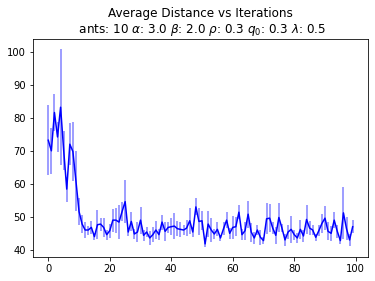

In [94]:
text_title = r"ants: {} $\alpha$: {} $\beta$: {} $\rho$: {} $q_0$: {} $\lambda$: {}".format(ants,alpha,beta,p,q_0, penalty)
plot_distance(history['distances_avg'], history['distances_sem'], add_title = text_title)

In [87]:
total_iter = 100
step_plot = 10

# Create the graph
graph = PPGraph(size = 20, tau_0 = tau_0)

# Create the optimizer using the current graph
optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)

# Execute the optimizer
history = optimizer.fit(total_iter)

[INFO] iter: 0 best: 52 d_mean: 73.2 d_stdv: 31.7011040817193
[INFO] iter: 10 best: 38 d_mean: 51.6 d_stdv: 12.092973166264779
[INFO] iter: 20 best: 38 d_mean: 45.8 d_stdv: 6.2257529665093525
[INFO] iter: 30 best: 38 d_mean: 49.0 d_stdv: 12.206555615733702
[INFO] iter: 40 best: 38 d_mean: 47.0 d_stdv: 7.496665925596525
[INFO] iter: 50 best: 38 d_mean: 48.8 d_stdv: 8.772684879784524
[INFO] iter: 60 best: 38 d_mean: 46.8 d_stdv: 10.43839068055991
[INFO] iter: 70 best: 38 d_mean: 42.8 d_stdv: 3.370459909270544
[INFO] iter: 80 best: 38 d_mean: 44.6 d_stdv: 4.476605857119878
[INFO] iter: 90 best: 38 d_mean: 49.6 d_stdv: 11.01998185116473


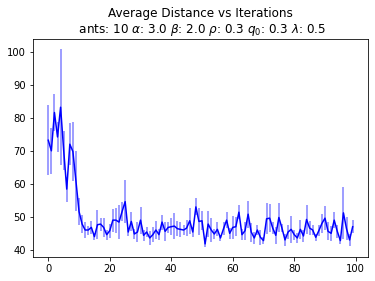

In [92]:
text_title = r"ants: {} $\alpha$: {} $\beta$: {} $\rho$: {} $q_0$: {} $\lambda$: {}".format(ants,alpha,beta,p,q_0, penalty)
plot_distance(history['distances_avg'], history['distances_sem'], add_title = text_title)

Execute the algorithm given some parameters in a **obstacle environment**

In [89]:
SIZE = 20
folder_dir = "stuff/data/random_mazes/maze_size_{}/".format(SIZE)
list_files = os.listdir(folder_dir)

maze_file = os.path.join(folder_dir,list_files[0])

In [90]:
# Define the parameters of our model
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0
q_0 = 0.3

# Additional attributes
penalty = 0.5 # Nota el grado de penalización provoca que haya mas o menos ruido

total_iter = 400
step_plot = 10

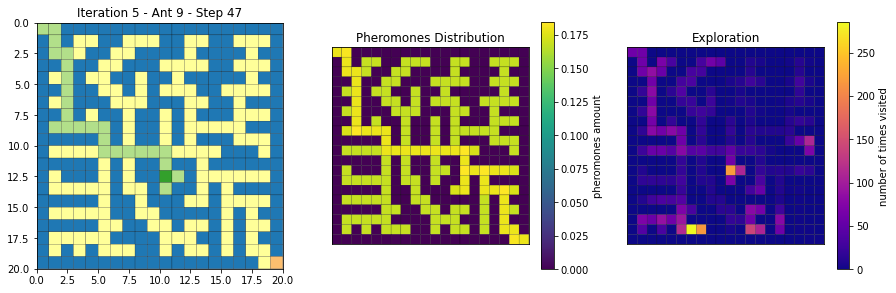

KeyboardInterrupt: 

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

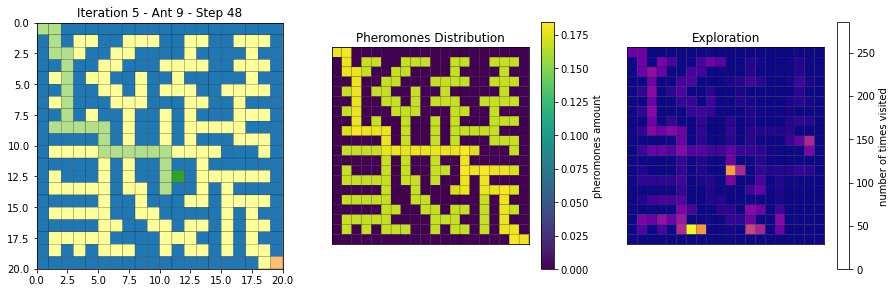

In [18]:
# Create the graph
graph = PPGraph(size = 20, tau_0 = tau_0, filename = maze_file)
# Create the envioronment
optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)

# Execute optimizer
history = optimizer.fit(total_iter, steps_die = 100, draw_mode = "per_iteration", iter_show = 5)

In [143]:
# Define the parameters of our model
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0
q_0 = 0.3

# Additional attributes
penalty = 0.7 # Nota el grado de penalización provoca que haya mas o menos ruido

total_iter = 100
step_plot = 10

In [144]:
# Create the graph
graph = PPGraph(size = 20, tau_0 = tau_0, filename = maze_file)
# Create the envioronment
optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)

# Execute optimizer
history = optimizer.fit(total_iter, steps_die = 100)

[INFO] iter: 0 best: 98 d_mean: 99.8 d_stdv: 0.6
[INFO] iter: 10 best: 38 d_mean: 38.8 d_stdv: 0.9797958971132712
[INFO] iter: 20 best: 38 d_mean: 39.8 d_stdv: 2.08806130178211
[INFO] iter: 30 best: 38 d_mean: 39.6 d_stdv: 2.4979991993593593
[INFO] iter: 40 best: 38 d_mean: 40.0 d_stdv: 2.8284271247461903
[INFO] iter: 50 best: 38 d_mean: 38.4 d_stdv: 0.7999999999999999
[INFO] iter: 60 best: 38 d_mean: 40.0 d_stdv: 3.0983866769659336
[INFO] iter: 70 best: 38 d_mean: 39.0 d_stdv: 1.8439088914585775
[INFO] iter: 80 best: 38 d_mean: 39.4 d_stdv: 2.3748684174075834
[INFO] iter: 90 best: 38 d_mean: 38.6 d_stdv: 0.9165151389911679


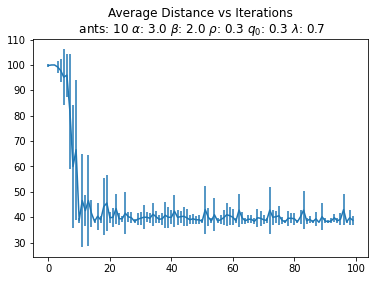

In [145]:
text_title = r"ants: {} $\alpha$: {} $\beta$: {} $\rho$: {} $q_0$: {} $\lambda$: {}".format(ants,alpha,beta,p,q_0, penalty)
plot_distance(history['distances_avg'], history['distances_std'], add_title = text_title)

In [146]:
#@title Function to display the histogram of pheromones
def display_pheromones(env, bins):
  #A = nx.attr_matrix(self.graph, edge_attr="pheromone", rc_order= np.arange(0,self.size * self.size))

  #print(A)
  edge_attributes = nx.get_edge_attributes(env.graph,'pheromone')

  pheromones = []
  phero_dist = []

  count = 0
  for _, _, attrib in env.graph.edges(data=True):
    pheromones.append(attrib['pheromone'])
    if attrib['pheromone'] == 0.1: count+=0

    phero_dist_val = (attrib['pheromone'] ** env.alpha) * (attrib['distance'] ** env.beta)
    phero_dist.append(phero_dist_val)

  fig, ax = plt.subplots(1,2, figsize = (10,5))
  ax[0].hist(pheromones, bins=bins)
  ax[0].set_title('Pheromones Distribution')

  ax[1].hist(phero_dist, bins=bins)
  ax[1].set_title('Pheromones-Distance Distribution')
  plt.show()

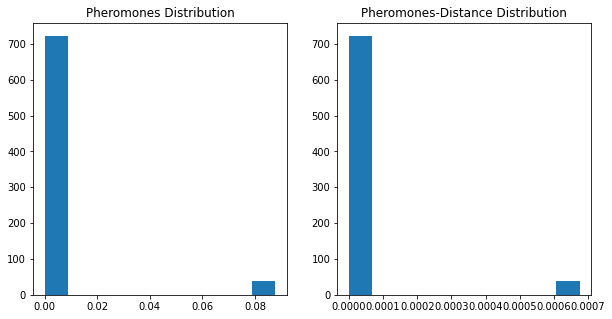

In [147]:
display_pheromones(optimizer,10)

### Experiments

In section, we performed experiments varying some relevant parameters and keep constant the other ones.

#### Penalties Behavior

In [154]:
# Varying penalty
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = None
q_0 = None

# Additional attributes
penalty_list = [0.3, 0.5, 0.7, 0.9] 

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 40
step_plot = 10

In [155]:
histories = []
for penalty in penalty_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

[INFO] iter: 0 best: 24 d_mean: 50.6 d_stdv: 18.569868066305695
[INFO] iter: 10 best: 20 d_mean: 50.6 d_stdv: 27.583328298086148
[INFO] iter: 20 best: 20 d_mean: 57.0 d_stdv: 40.7651812212334
[INFO] iter: 30 best: 20 d_mean: 67.8 d_stdv: 47.25632232834036
[INFO] iter: 0 best: 20 d_mean: 38.6 d_stdv: 20.919847035769646
[INFO] iter: 10 best: 20 d_mean: 44.4 d_stdv: 30.486718419665962
[INFO] iter: 20 best: 20 d_mean: 24.6 d_stdv: 5.7306195127577615
[INFO] iter: 30 best: 20 d_mean: 28.8 d_stdv: 8.35224520712844
[INFO] iter: 0 best: 22 d_mean: 50.8 d_stdv: 33.872702874143364
[INFO] iter: 10 best: 18 d_mean: 20.2 d_stdv: 5.3999999999999995
[INFO] iter: 20 best: 18 d_mean: 18.4 d_stdv: 0.8
[INFO] iter: 30 best: 18 d_mean: 19.4 d_stdv: 2.009975124224178
[INFO] iter: 0 best: 20 d_mean: 31.2 d_stdv: 8.541662601625049
[INFO] iter: 10 best: 18 d_mean: 18.0 d_stdv: 0.0
[INFO] iter: 20 best: 18 d_mean: 18.0 d_stdv: 0.0
[INFO] iter: 30 best: 18 d_mean: 18.0 d_stdv: 0.0


In [156]:
#@title Function to plot the best distance per iteration
# plot the best distance per iteration
def plot_many_distances(histories, constant_params, var_name, variable_params, save = False, name2save = ""):

  list_iterations = np.arange(0, len(histories[0]['distances_avg']))


  title = 'Average Distance vs Iterations \n'
  for k, v in constant_params.items():
    title += "{}: {} ".format(k, v)
  figure(figsize=(10, 5), dpi=80)
  plt.title(title)
  
  min = np.amin(histories[0]['distances_best'])
  for param, history in zip(variable_params, histories):
    label = str(param)
    plt.plot(list_iterations, history['distances_avg'], "-", label = label)
    plt.fill_between(list_iterations, 
                     np.clip(np.array(history['distances_avg']) - np.array(history['distances_sem']),min,float('inf')), 
                     np.array(history['distances_avg']) + np.array(history['distances_sem']), 
                     alpha=0.2)
  plt.legend(title=var_name)
  #if save: plt.savefig(os.path.join(path_to_save,name2save))

  plt.show()
  plt.close()

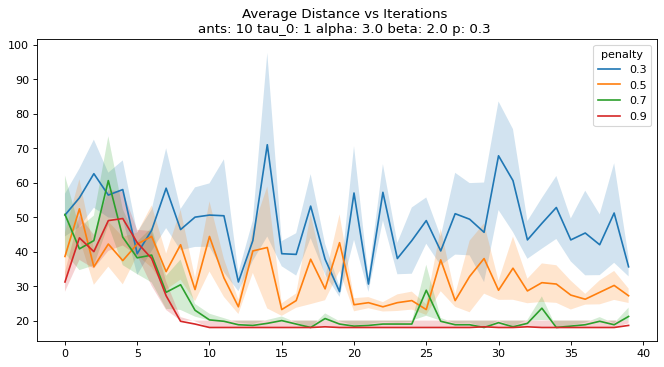

In [157]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p
}
plot_many_distances(histories[-4:],constant_params, "penalty", penalty_list[-4:])

#### Local Pheromone Evaporation Variation

In [160]:
# Varying penalty
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p_list = [0.3, 0.5, 0.7, 0.9]
q_0 = None

# Additional attributes
penalty = 0.5

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 100
step_plot = 10

In [161]:
histories = []
for local_p in local_p_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

[INFO] iter: 0 best: 26 d_mean: 42.8 d_stdv: 9.173875952943773
[INFO] iter: 10 best: 18 d_mean: 46.8 d_stdv: 16.951696080333672
[INFO] iter: 20 best: 18 d_mean: 64.6 d_stdv: 50.83345355177041
[INFO] iter: 30 best: 18 d_mean: 40.4 d_stdv: 18.478095139921756
[INFO] iter: 40 best: 18 d_mean: 50.6 d_stdv: 36.84616669342959
[INFO] iter: 50 best: 18 d_mean: 40.4 d_stdv: 20.214846029589246
[INFO] iter: 60 best: 18 d_mean: 58.8 d_stdv: 25.031180555459223
[INFO] iter: 70 best: 18 d_mean: 37.4 d_stdv: 18.847811544049353
[INFO] iter: 80 best: 18 d_mean: 71.6 d_stdv: 50.17409690268476
[INFO] iter: 90 best: 18 d_mean: 88.6 d_stdv: 48.26634438198112
[INFO] iter: 0 best: 20 d_mean: 30.8 d_stdv: 10.777754868245983
[INFO] iter: 10 best: 20 d_mean: 36.0 d_stdv: 14.939879517586478
[INFO] iter: 20 best: 18 d_mean: 40.2 d_stdv: 22.599999999999998
[INFO] iter: 30 best: 18 d_mean: 42.0 d_stdv: 26.2449995237188
[INFO] iter: 40 best: 18 d_mean: 48.4 d_stdv: 22.53530563360524
[INFO] iter: 50 best: 18 d_mean: 73

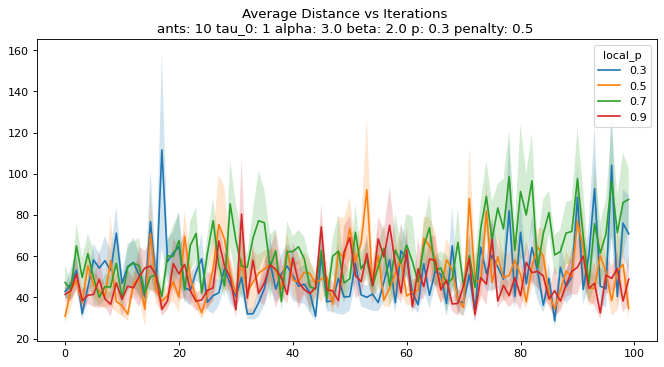

In [162]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty
}
plot_many_distances(histories[-4:], constant_params, "local_p", local_p_list[-4:])

#### q_0 Parameter Variation

In [163]:
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0.3
q_0_list = [0.3, 0.5, 0.7, 0.9]

# Additional attributes
penalty = 0.5

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 200
step_plot = 10

In [164]:
histories = []
for q_0 in q_0_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

[INFO] iter: 0 best: 20 d_mean: 30.6 d_stdv: 8.534635317340747
[INFO] iter: 10 best: 18 d_mean: 27.4 d_stdv: 8.627861844049196
[INFO] iter: 20 best: 18 d_mean: 30.4 d_stdv: 9.789790600416334
[INFO] iter: 30 best: 18 d_mean: 27.8 d_stdv: 8.829496021857645
[INFO] iter: 40 best: 18 d_mean: 34.6 d_stdv: 18.526737435393205
[INFO] iter: 50 best: 18 d_mean: 22.8 d_stdv: 4.749736834815167
[INFO] iter: 60 best: 18 d_mean: 24.4 d_stdv: 3.4409301068170506
[INFO] iter: 70 best: 18 d_mean: 22.0 d_stdv: 2.0
[INFO] iter: 80 best: 18 d_mean: 21.6 d_stdv: 3.2
[INFO] iter: 90 best: 18 d_mean: 19.0 d_stdv: 1.8439088914585775
[INFO] iter: 100 best: 18 d_mean: 19.6 d_stdv: 1.9595917942265424
[INFO] iter: 110 best: 18 d_mean: 19.8 d_stdv: 1.661324772583615
[INFO] iter: 120 best: 18 d_mean: 21.4 d_stdv: 4.476605857119878
[INFO] iter: 130 best: 18 d_mean: 22.0 d_stdv: 4.1952353926806065
[INFO] iter: 140 best: 18 d_mean: 19.8 d_stdv: 2.2715633383201093
[INFO] iter: 150 best: 18 d_mean: 21.2 d_stdv: 3.124099870

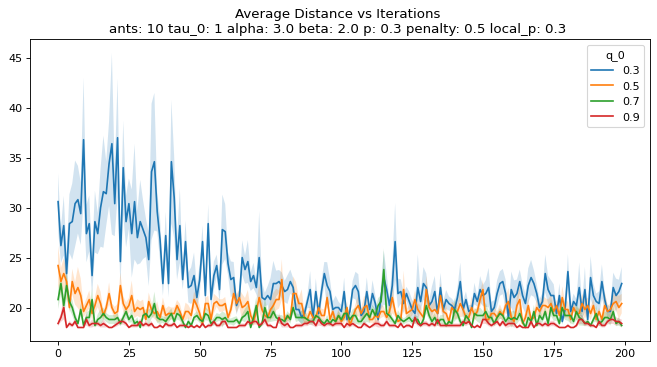

In [165]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty,
    "local_p" : local_p
}
plot_many_distances(histories[-4:], constant_params, "q_0", q_0_list[-4:])

In [172]:
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0
q_0_list = [0.3, 0.5, 0.7, 0.9]

# Additional attributes
penalty = 0.7

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 30
step_plot = 10

In [173]:
histories = []
for q_0 in q_0_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

[INFO] iter: 0 best: 20 d_mean: 27.2 d_stdv: 6.764613810115105
[INFO] iter: 10 best: 18 d_mean: 19.2 d_stdv: 2.5612496949731396
[INFO] iter: 20 best: 18 d_mean: 19.2 d_stdv: 3.6
[INFO] iter: 0 best: 20 d_mean: 26.2 d_stdv: 6.2257529665093525
[INFO] iter: 10 best: 18 d_mean: 18.6 d_stdv: 1.2806248474865698
[INFO] iter: 20 best: 18 d_mean: 19.2 d_stdv: 2.993325909419153
[INFO] iter: 0 best: 18 d_mean: 19.0 d_stdv: 1.3416407864998738
[INFO] iter: 10 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 20 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 0 best: 18 d_mean: 18.8 d_stdv: 0.9797958971132712
[INFO] iter: 10 best: 18 d_mean: 18.2 d_stdv: 0.6
[INFO] iter: 20 best: 18 d_mean: 18.0 d_stdv: 0.0


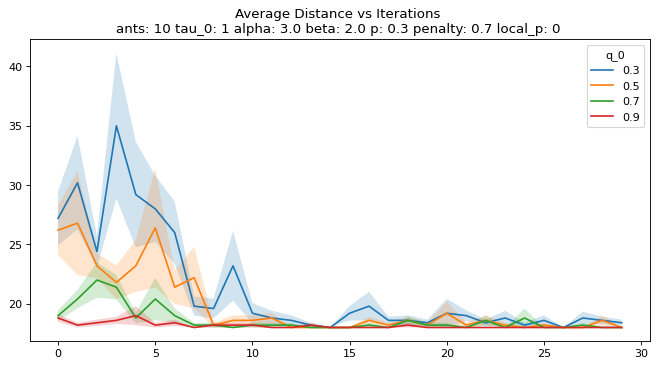

In [174]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty,
    "local_p" : local_p
}
plot_many_distances(histories[-4:], constant_params, "q_0", q_0_list[-4:])

In [ ]:
ants = 10
tau_0 = 1
alpha = 3. 
beta = 2.
p = 0.3
intensity = None
local_p = 0.3
q_0_list = [0.3, 0.5, 0.7, 0.9]

# Additional attributes
penalty = 0.3

# Nota el grado de penalización provoca que haya mas o menos ruido
total_iter = 200
step_plot = 10

In [ ]:
histories = []
for q_0 in q_0_list:
  # Create the graph
  graph = PPGraph(size = 10, tau_0 = tau_0)
  # Create the envioronment
  optimizer = ACOPP(graph, ants, alpha, beta, p, penalty, local_p, intensity, q_0)
  #draw_grid(optimizer)
  #display_pheromones(optimizer,10)
  history = optimizer.fit(total_iter)
  histories.append(history)

[INFO] iter: 0 best: 24 d_mean: 29.2 d_stdv: 4.308131845707604
[INFO] iter: 10 best: 18 d_mean: 26.8 d_stdv: 5.81033561853358
[INFO] iter: 20 best: 18 d_mean: 27.6 d_stdv: 8.662563131083086
[INFO] iter: 30 best: 18 d_mean: 30.2 d_stdv: 10.371113729971338
[INFO] iter: 40 best: 18 d_mean: 29.4 d_stdv: 7.045565981523415
[INFO] iter: 50 best: 18 d_mean: 33.8 d_stdv: 9.271461589199408
[INFO] iter: 60 best: 18 d_mean: 36.0 d_stdv: 13.053735097664577
[INFO] iter: 70 best: 18 d_mean: 30.8 d_stdv: 4.995998398718719
[INFO] iter: 80 best: 18 d_mean: 28.6 d_stdv: 11.421033228215387
[INFO] iter: 90 best: 18 d_mean: 36.6 d_stdv: 21.799999999999997
[INFO] iter: 100 best: 18 d_mean: 26.4 d_stdv: 3.9799497484264794
[INFO] iter: 110 best: 18 d_mean: 37.8 d_stdv: 19.727138667328315
[INFO] iter: 120 best: 18 d_mean: 38.2 d_stdv: 19.502820308868152
[INFO] iter: 130 best: 18 d_mean: 31.8 d_stdv: 15.42595215861893
[INFO] iter: 140 best: 18 d_mean: 28.2 d_stdv: 9.526804291051644
[INFO] iter: 150 best: 18 d_me

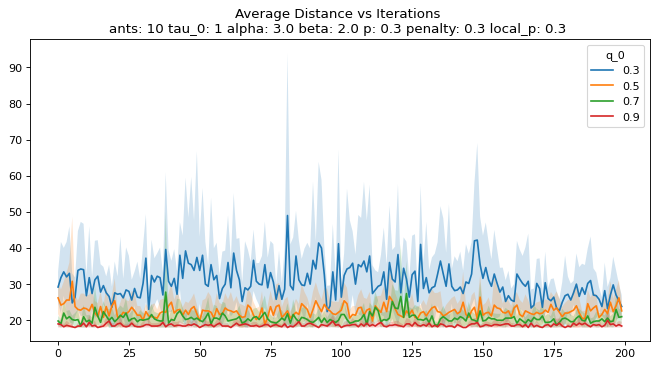

In [ ]:
constant_params = {
    "ants": ants ,
    "tau_0": tau_0,
    "alpha": alpha,
    "beta": beta,
    "p": p,
    "penalty" : penalty,
    "local_p" : local_p
}
plot_many_distances(histories[-4:], constant_params, "q_0", q_0_list[-4:])